# Import

In [ ]:
!pip install plotly --upgrade

In [ ]:
import glob
import os
import pickle

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import calinski_harabasz_score

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import davies_bouldin_score

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Functions

In [ ]:
def load_model(path_model):
  """
  permite cargar un modelo pkl

  path_model: es la ruta de acceso del modelo

  esta funcion se debe asignar a una variable para que el modelo quede guardado ahi
  """

  l_file = open(path_model, "rb") #aqui lo leo
  model = pickle.load(l_file) #lo asigno a una variable
  l_file.close() #lo cierro

  return model

In [ ]:
def save_model(model, path_save):
  """
  permite guardar un modelo pkl

  model: el modelo que se quiere guardar

  path_model: es la ruta donde se guardará el archivo. Recuerde escribir el nombre del archivo y su extensión
  (e.g. /content/drive/MyDrive/Modelos_TesisMaster/PKL/denoise_audios.pkl )

  """
  s_file = open(path_save, "wb") #creo un archivo para escribir
  pickle.dump(model, s_file) # escribo sobre el archivo
  s_file.close() #lo cierro

In [ ]:
def dim_reduction_PCA (model,n_comp):

  # get a list of the filenames
  labels = np.array(list(model.keys()))
  # get a list of just the features
  feat = np.array(list(model.values()))
  x=feat.shape[2]
  feat_re = feat.reshape(-1, x)

  pca_model=PCA(n_components=n_comp, random_state=42)
  pca_model.fit(feat_re)
  vector_feat = pca_model.transform(feat_re)

  return labels, vector_feat

In [ ]:
def dim_reduction_TSNE(model, n_comp):
  """
  esta es una reduccion dimesional pero utilizando el t-Distributed Stochastic Neighbor Embedding (T-SNE)
  # data es tu conjunto de datos de entrada (ndarray o dataframe)
  # n_components es el número de dimensiones deseadas en el conjunto de datos reducido
  # perplexity es un hiperparámetro de T-SNE que controla la confusión en la distancia entre puntos
  # random_state es un valor para inicializar la semilla del generador de números aleatorios

  """

  labels = np.array(list(model.keys()))
  feat = np.array(list(model.values()))
  x=feat.shape[2]
  feat_re = feat.reshape(-1, x)

  tsne = TSNE(n_components=n_comp, perplexity=30, random_state=42)
  data_reduced = tsne.fit_transform(feat_re)

  return labels, data_reduced


In [ ]:
def plot3d(data_frame, titulo):
  """
  Esta funcion me permite crear plots 3d utilizando plotly express

  data_frame: una objeto pandas dataframe con 4 columnas (x,y,z,label)
  titulo: el titulo que se le quiera dar al plot

  """

  fig1 = px.scatter_3d(data_frame, x='x', y='y', z='z',
                    color='label',
                    title=str(titulo),
                    template='simple_white',
                    labels={'x':'Eje X', 'y':'Eje Y', 'z':'Eje Z', 'label':'Latitud'},
                    height=700)

  fig2 = px.line_3d(data_frame, x='x', y='y', z='z',
                    color='label',
                    title='Scatter Plot 3D con etiquetas',
                    template='simple_white',
                    labels={'x':'Eje X', 'y':'Eje Y', 'z':'Eje Z', 'label':'Latitud'},
                    height=700)

  fig = go.Figure(data=fig1.data + fig2.data, layout = fig1.layout)

  return fig.show()

In [ ]:
def var_exp_acu_PCA (model):
  """
  funcion para obtener la varianza acumulada


  """

  # get a list of the filenames
  labels = np.array(list(model.keys()))
  # get a list of just the features
  feat = np.array(list(model.values()))
  x=feat.shape[2]
  X = feat.reshape(-1, x)

  # Crear una instancia de PCA
  pca = PCA(random_state=42)

  # Ajustar PCA al conjunto de datos
  pca.fit(X)

  # Obtener la varianza explicada acumulada
  var_exp = pca.explained_variance_ratio_
  cum_var_exp = np.cumsum(var_exp)

  return var_exp, cum_var_exp

In [ ]:
def scores_silhouettes(model):

  points_array = model

  # Creamos una lista para almacenar los Silhouette Scores
  scores_sil_k = []

  # Iteramos sobre un rango de valores de k
  for k in range(2, 458,20):
      # Creamos una instancia del algoritmo K-means
      kmeans = KMeans(n_clusters=k)
      # Entrenamos el modelo con los datos
      kmeans.fit(points_array)
      # Obtenemos las etiquetas de cada punto
      labels = kmeans.labels_
      # Calculamos el Silhouette Score
      score = silhouette_score(points_array, labels)
      # Agregamos el score a la lista
      scores_sil_k.append(score)


  return scores_sil_k

In [ ]:
def metodos_kmeans(model):

  points_array = model

  sse_elb = [] #lista para almacenar los sse provenientes de elbow method
  scores_sil = [] #lista para almacenar los scores del silhouette
  scores_cali = [] #lista para almacenar los scores de Calinski

  # Iteramos sobre un rango de valores de k
  for k in range(2, 458, 20):#en primncipio debe venir aasi range(2, 458, 20)
      # Creamos una instancia del algoritmo K-means
      kmeans = KMeans(n_clusters=k, random_state=42)
      # Entrenamos el modelo con los datos
      kmeans.fit(points_array)
      # Obtenemos las etiquetas de cada punto
      labels = kmeans.labels_
      # Calculamos el Silhouette Score
      score_s = silhouette_score(points_array, labels)
      # Agregamos el score a la lista
      scores_sil.append(score_s)

      #Calculamos los sse
      sse_elb.append(kmeans.inertia_)

      # Calculamos el score de Calinski-Harabasz
      score_c = calinski_harabasz_score(points_array, labels)
      # Agregamos el score a la lista
      scores_cali.append(score_c)


  return sse_elb, scores_sil, scores_cali

In [ ]:
def metodos_agglomerative(X):

    clusters=list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))

    sil_AC=[] #lista para silueta
    cop_AC = [] #lista para cophenetica
    dabo_AC =[] #lista para Davies-Bouldin
    cali_AC =[] #Caliski


    for num_clusters in clusters:
        model = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
        model.fit(X)
        labels = model.labels_

        #para silueta
        sil_AC.append(silhouette_score(X, labels))

        #para cophenetica
        linkage_matrix = linkage(X, "ward")
        c, coph_dists = cophenet(linkage_matrix, pdist(X))
        cop_AC.append(c)

        #para Davies-Bouldin
        d = davies_bouldin_score(X, labels)
        dabo_AC.append(d)

        # Calcula el índice de Calinski-Harabasz
        k = calinski_harabasz_score(X, labels)
        cali_AC.append(k)


    return sil_AC, cop_AC, dabo_AC, cali_AC

# Espectrogramas PIL

In [ ]:
spectrogramas44k=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/spectrogramas44k.pkl")

In [ ]:
spectrogramas44k['XC395416_1']

# Unidades de muestreo

Para evitar el remuestreo lo que vamos a hacer es crear grupos compuestos por 1 vocalizacion seleccionada completamente al azar por individuo. Es decir, cada grupo tendrá 1 sola vocalizacion de 458 individuos diferentes.

La pregunta es, cuantos grupos crear?

In [ ]:
spec_full_df=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/spec_full_df.pkl")

In [ ]:
lat_labels=pd.read_csv('/content/drive/MyDrive/Modelos_TesisMaster/Dataframes/lat_labels.csv')

In [ ]:
id_XC=list(lat_labels.id_XC)

In [ ]:
cantidad_clips={}

for i in id_XC:

  x=spec_full_df.loc[spec_full_df['label'].str.contains(i)]
  cantidad=len(x.label)

  cantidad_clips[i]=cantidad

In [ ]:
cantidad_clips_values=list(cantidad_clips.values())

In [ ]:
import statistics as stat

moda=stat.mode(cantidad_clips_values)
mediana=stat.median(cantidad_clips_values)
average=stat.mean(cantidad_clips_values)

print(f"""
      moda:{moda}
      mediana:{mediana}
      promedio:{average}""")

from collections import Counter
a=Counter(cantidad_clips_values).most_common()
print(a)


      moda:4
      mediana:7.0
      promedio:9.663755458515285
[(4, 54), (3, 51), (5, 38), (6, 37), (7, 32), (2, 29), (8, 24), (9, 22), (10, 21), (11, 18), (1, 14), (17, 12), (16, 12), (13, 11), (14, 11), (12, 10), (15, 9), (30, 7), (20, 7), (19, 4), (23, 3), (24, 3), (29, 2), (22, 2), (32, 2), (38, 2), (47, 2), (37, 2), (21, 2), (18, 2), (26, 2), (43, 1), (33, 1), (73, 1), (56, 1), (69, 1), (39, 1), (25, 1), (46, 1), (48, 1), (28, 1), (36, 1)]


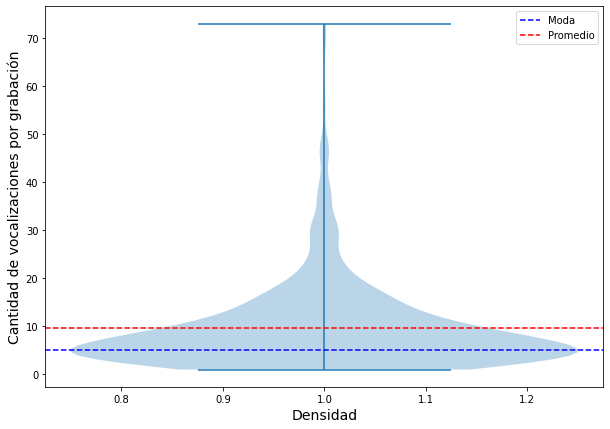

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))

hvfont = {'fontname':'Calibri', 'fontsize': 14,}
#fontdict={'fontsize': 14, 'fontweight': 'medium'}

# Creating plot
plt.violinplot(cantidad_clips_values)
#plt.boxplot(cantidad_clips_values)

# line colour is blue
plt.axhline(y = 5, color = 'b', linestyle = 'dashed', label = "Moda")

# line colour is white
#plt.axhline(y = mediana, color = 'orange', linestyle = '--', label = "median")

# line colour is red
plt.axhline(y = average, color = 'r', linestyle = 'dashed', label = "Promedio")

# adding axis labels
plt.xlabel('Densidad',**hvfont)
plt.ylabel('Cantidad de vocalizaciones por grabación', **hvfont)

# plotting the legend
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper right')

# show plot
plt.show()

Se utilizaron medidas de tendencia (mediana, moda y promedio) para determinar en general cuantas vocalizaciones habia por individuo. En el grafico se observa como la mayor parte de individuos presenta en sus grabaciones entre 4 y 10 vocalizaciones, muy pocos individuos tienen grabaciones con mas de 20 vocalizaciones. Entonces, lo que a hacer es generar 10 grupos, cada grupo tendra 1 sola vocalización por individuo por lo que cada grupo tendrá 458 grabaciones, todo esto será complemente al azar.

In [ ]:
spec_full_df.lat_label.value_counts()

35N    888
45N    436
5S     387
40N    337
25S    321
25N    270
5N     269
20N    257
10N    254
15N    186
30N    186
35S    143
15S    127
20S    109
50N     85
30S     57
55N     48
10S     45
45S      9
40S      9
55S      3
Name: lat_label, dtype: int64

creamos un diccionario que contenga otro diccionario. El primer nivel nos indicará el grupo y el segundo es el id de cada individuo precedido por el numero de la vocalización. *dict [grupo] [id_vocalizacion]*

In [ ]:
import random

random.seed(42)#plantamos la semilla en 42 para replicar
samples={}
contador=1
num_samples=10 #solo 10 grupos


while contador<=num_samples:

  lista_id_random=[]

  for i in id_XC:

    x=spec_full_df.loc[spec_full_df['label'].str.contains(i)]
    slices=list(x.label)
    y=random.choice(slices)
    lista_id_random.append(y)

    samples[contador]=lista_id_random

  contador+=1


In [ ]:
samples[10][:10]

['XC728656_10',
 'XC728445_1',
 'XC728444_2',
 'XC727098_1',
 'XC726630_5',
 'XC724835_4',
 'XC723373_13',
 'XC711290_5',
 'XC705153_5',
 'XC701239_14']

In [ ]:
save_model(samples,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/samples.pkl")

In [ ]:
samples=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/samples.pkl")

Listo! el diccionario se llama samples y es donde se encuentran los id's y las vocalizaciones elegidas al azar de cada uno de los 458 individuos

In [ ]:
features_1R_full_VGG16=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG16.pkl")
features_1R_full_VGG19=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG19.pkl")
features_1R_full_res50=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_res50.pkl")
features_1R_full_v3=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_v3.pkl")
features_1R_full_x=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_x.pkl")

In [ ]:
features_1R_full_VGG16_Groups={}
features_1R_full_VGG19_Groups={}
features_1R_full_res50_Groups={}
features_1R_full_v3_Groups={}
features_1R_full_x_Groups={}

contador_grupo=1
max_grupos=10

#VGG16
while contador_grupo<=max_grupos:
  grupo={}

  for i in samples[contador_grupo]:
    grupo[i]=features_1R_full_VGG16[i]

  features_1R_full_VGG16_Groups[contador_grupo]=grupo

  contador_grupo+=1



#VGG19
contador_grupo=1
max_grupos=10

while contador_grupo<=max_grupos:
  grupo={}

  for i in samples[contador_grupo]:
    grupo[i]=features_1R_full_VGG19[i]

  features_1R_full_VGG19_Groups[contador_grupo]=grupo

  contador_grupo+=1



#RES50
contador_grupo=1
max_grupos=10

while contador_grupo<=max_grupos:
  grupo={}

  for i in samples[contador_grupo]:
    grupo[i]=features_1R_full_res50[i]

  features_1R_full_res50_Groups[contador_grupo]=grupo

  contador_grupo+=1


#IncetionV3
contador_grupo=1
max_grupos=10

while contador_grupo<=max_grupos:
  grupo={}

  for i in samples[contador_grupo]:
    grupo[i]=features_1R_full_v3[i]

  features_1R_full_v3_Groups[contador_grupo]=grupo

  contador_grupo+=1


#Xception
contador_grupo=1
max_grupos=10

while contador_grupo<=max_grupos:
  grupo={}

  for i in samples[contador_grupo]:
    grupo[i]=features_1R_full_x[i]

  features_1R_full_x_Groups[contador_grupo]=grupo

  contador_grupo+=1


In [ ]:
a=features_1R_full_VGG16_Groups[10]['XC728656_10']
b=features_1R_full_VGG19_Groups[10]['XC727098_1']
c=features_1R_full_res50_Groups[10]['XC701239_14']
d=features_1R_full_v3_Groups[10]['XC723373_13']
e=features_1R_full_x_Groups[10]['XC711290_5']

vocals=(a,b,c,d,e)
for i in vocals:
  print(i.shape)


(1, 4096)
(1, 4096)
(1, 2048)
(1, 2048)
(1, 2048)


In [ ]:
save_model(features_1R_full_VGG16_Groups,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG16_Groups.pkl" )
save_model(features_1R_full_VGG19_Groups,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG19_Groups.pkl" )
save_model(features_1R_full_res50_Groups,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_res50_Groups.pkl" )
save_model(features_1R_full_v3_Groups,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_v3_Groups.pkl" )
save_model(features_1R_full_x_Groups,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_x_Groups.pkl" )

In [ ]:
#features_1R_full_VGG16_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG16_Groups.pkl" )
#features_1R_full_VGG19_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG19_Groups.pkl" )
#features_1R_full_res50_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_res50_Groups.pkl" )
features_1R_full_v3_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_v3_Groups.pkl" )
features_1R_full_x_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_x_Groups.pkl" )

Ya estan los grupos creados!! ahora el 'problema' es que debemos optimizar los recursos computacionales que tenemos y como vimos mas arriba, despues de pasar por el extractor de caracteristicas cada vocalización se ha convertido en una matriz de tamaño (1,4096) o (1,2048) segun el tipo de extractor. Estas matrices son muy grandes y al pasar por algoritmos de clustering que calculan iterativamente distancias entre instancias, la cantidad de calculos es demasiado grande y saturaria la memoria RAM disponible, ademas de demorarse mucho.

Por esta razón vamos a reducir su dimensionalidad con un PCA. El problema ahora es saber cuantos componentes elegir?

#Visualización 3D del conglomerado

primero vamos a hacer una reduccion dimensional a solo 3 componentes principales con el fin de poder representar la ubicacion de los puntos en un grafico 3d

cargamos los diccionarios que contienen los grupos

In [ ]:
features_1R_full_VGG16_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG16_Groups.pkl" )
features_1R_full_VGG19_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_VGG19_Groups.pkl" )
features_1R_full_res50_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_res50_Groups.pkl" )
features_1R_full_v3_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_v3_Groups.pkl" )
features_1R_full_x_Groups=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/features_1R_full_x_Groups.pkl" )

elegimos algun grupo al azar para crear el plot

In [ ]:
VGG16_3D=features_1R_full_VGG16_Groups[1]
VGG19_3D=features_1R_full_VGG19_Groups[3]
Res50_3D=features_1R_full_res50_Groups[8]
v3_3D=features_1R_full_v3_Groups[5]
x_3D=features_1R_full_x_Groups[10]

hacemos la reduccion dimensional a 3dimensiones

In [ ]:
labels_vgg16_3d, feat_vgg16_3d=dim_reduction_PCA(VGG16_3D,3)
labels_vgg19_3d, feat_vgg19_3d=dim_reduction_PCA(VGG19_3D,3)
labels_res50_3d, feat_res50_3d=dim_reduction_PCA(Res50_3D,3)
labels_v3_3d, feat_v3_3d=dim_reduction_PCA(v3_3D,3)
labels_x_3d, feat_x_3d=dim_reduction_PCA(x_3D,3)

#labels_vgg16_3d_tsne, feat_vgg16_3d_tsne=dim_reduction_TSNE(VGG16_3D,3)
#labels_vgg19_3d_tsne, feat_vgg19_3d_tsne=dim_reduction_TSNE(VGG19_3D,3)
#labels_res50_3d_tsne, feat_res50_3d_tsne=dim_reduction_TSNE(Res50_3D,3)
#labels_v3_3d_tsne, feat_v3_3d_tsne=dim_reduction_TSNE(v3_3D,3)
#labels_x_3d_tsne, feat_x_3d_tsne=dim_reduction_TSNE(x_3D,3)

creamos una lista con los labels correspondientes a la latitud de cada individuo, con ello podremos diferenciar a los individuos cercanos geograficamente

In [ ]:
#para vgg16
label_lat_vgg16=[]
for i in labels_vgg16_3d:
  x = spec_full_df.loc[spec_full_df['label'] == i, 'lat_label'].values[0]
  label_lat_vgg16.append(x)
#para vgg19
label_lat_vgg19=[]
for i in labels_vgg19_3d:
  x = spec_full_df.loc[spec_full_df['label'] == i, 'lat_label'].values[0]
  label_lat_vgg19.append(x)
#para res50
label_lat_res50=[]
for i in labels_res50_3d:
  x = spec_full_df.loc[spec_full_df['label'] == i, 'lat_label'].values[0]
  label_lat_res50.append(x)
  #para inceptionv3
label_lat_v3=[]
for i in labels_v3_3d:
  x = spec_full_df.loc[spec_full_df['label'] == i, 'lat_label'].values[0]
  label_lat_v3.append(x)
  #para xception
label_lat_x=[]
for i in labels_x_3d:
  x = spec_full_df.loc[spec_full_df['label'] == i, 'lat_label'].values[0]
  label_lat_x.append(x)


## Plots con T-SNE

In [ ]:
#este es el que funciona
import pandas as pd
import plotly.express as px

# Crea un dataframe con tus datos
data_vgg16_tsne = {'x': feat_vgg16_3d_tsne[:,0],
        'y': feat_vgg16_3d_tsne[:,1],
        'z': feat_vgg16_3d_tsne[:,2],
        'label': label_lat_vgg16}
dataframe_vgg16_tsne = pd.DataFrame(data_vgg16_tsne)

plot3d(dataframe_vgg16_tsne, 'Dristribución espacial de las caracteristicas extraidas por VGG16 - tsne')


In [ ]:
# Crea un dataframe con tus datos
data_vgg19_tsne = {'x': feat_vgg19_3d_tsne[:,0],
        'y': feat_vgg19_3d_tsne[:,1],
        'z': feat_vgg19_3d_tsne[:,2],
        'label': label_lat_vgg19}
dataframe_vgg19_tsne = pd.DataFrame(data_vgg19_tsne)

plot3d(dataframe_vgg19_tsne, 'Dristribución espacial de las caracteristicas extraidas por VGG19 - tsne')

In [ ]:
# Crea un dataframe con tus datos
data_res50_tsne = {'x': feat_res50_3d_tsne[:,0],
        'y': feat_res50_3d_tsne[:,1],
        'z': feat_res50_3d_tsne[:,2],
        'label': label_lat_res50}
dataframe_res50_tsne = pd.DataFrame(data_res50_tsne)

plot3d(dataframe_res50_tsne, 'Dristribución espacial de las caracteristicas extraidas por res50 - tsne')

In [ ]:
# Crea un dataframe con tus datos
data_v3_tsne = {'x': feat_v3_3d_tsne[:,0],
        'y': feat_v3_3d_tsne[:,1],
        'z': feat_v3_3d_tsne[:,2],
        'label': label_lat_v3}
dataframe_v3_tsne = pd.DataFrame(data_v3_tsne)

plot3d(dataframe_v3_tsne, 'Dristribución espacial de las caracteristicas extraidas por InceptionV3 - tsne')

In [ ]:
# Crea un dataframe con tus datos
data_x_tsne = {'x': feat_x_3d_tsne[:,0],
        'y': feat_x_3d_tsne[:,1],
        'z': feat_x_3d_tsne[:,2],
        'label': label_lat_x}
dataframe_x_tsne = pd.DataFrame(data_x_tsne)

plot3d(dataframe_x_tsne, 'Dristribución espacial de las caracteristicas extraidas por Xception - tsne')

## Plots con PCA

In [ ]:
#este es el que funciona
import pandas as pd
import plotly.express as px

# Crea un dataframe con tus datos
data_vgg16 = {'x': feat_vgg16_3d[:,0],
        'y': feat_vgg16_3d[:,1],
        'z': feat_vgg16_3d[:,2],
        'label': label_lat_vgg16}
dataframe_vgg16 = pd.DataFrame(data_vgg16)

plot3d(dataframe_vgg16, 'Distribución espacial de las características extraídas por VGG16')


In [ ]:
# Crea un dataframe con tus datos
data_vgg19 = {'x': feat_vgg19_3d[:,0],
        'y': feat_vgg19_3d[:,1],
        'z': feat_vgg19_3d[:,2],
        'label': label_lat_vgg19}
dataframe_vgg19 = pd.DataFrame(data_vgg19)

plot3d(dataframe_vgg19, 'Distribución espacial de las características extraídas por VGG19')

In [ ]:
# Crea un dataframe con tus datos
data_res50 = {'x': feat_res50_3d[:,0],
        'y': feat_res50_3d[:,1],
        'z': feat_res50_3d[:,2],
        'label': label_lat_res50}
dataframe_res50 = pd.DataFrame(data_res50)

plot3d(dataframe_res50, 'Distribución espacial de las características extraídas por res50')

In [ ]:
# Crea un dataframe con tus datos
data_v3 = {'x': feat_v3_3d[:,0],
        'y': feat_v3_3d[:,1],
        'z': feat_v3_3d[:,2],
        'label': label_lat_v3}
dataframe_v3 = pd.DataFrame(data_v3)

plot3d(dataframe_v3, 'Distribución espacial de las características extraídas por InceptionV3')

In [ ]:
# Crea un dataframe con tus datos
data_x = {'x': feat_x_3d[:,0],
        'y': feat_x_3d[:,1],
        'z': feat_x_3d[:,2],
        'label': label_lat_x}
dataframe_x = pd.DataFrame(data_x)

plot3d(dataframe_x, 'Distribución espacial de las características extraídas por Xception')

# Reducción dimensional (PCA)

como hemos visto anteriormente, los vectores obtenidos despues de la extraccion de carcteriticas tienen una forma (1,4096) para los VGG16 y VGG19 y (1,2048) para los res50, InceptionV3 y Xception. Estos son vectores muy grandes que al momento de ser usados en un algoritmo de clustering acabará con los recursos computacionales debido a la gran cantidad de calculos iterativos que realiza.

Por ende debemos reducir el tamaño de estos vectores procurando la menor perdida de información posible.

Para ello vamos a utilizar el analisis de componentes principales (PCA) y determinaremos la cantidad optima de componentes por medio el uso de la técnica llamada 'gráfico de varianzza explicada acumulada'

In [ ]:
import matplotlib.pyplot as plt

# Borrar el caché de Matplotlib
plt.rcParams.clear()

In [ ]:
var_exp16, cum_var_exp16 = var_exp_acu_PCA(features_1R_full_VGG16)
var_exp19, cum_var_exp19 = var_exp_acu_PCA(features_1R_full_VGG19)
var_expres50, cum_var_expres50 = var_exp_acu_PCA(features_1R_full_res50)
var_expv3, cum_var_expv3 = var_exp_acu_PCA(features_1R_full_v3)
var_expx, cum_var_expx = var_exp_acu_PCA(features_1R_full_x)

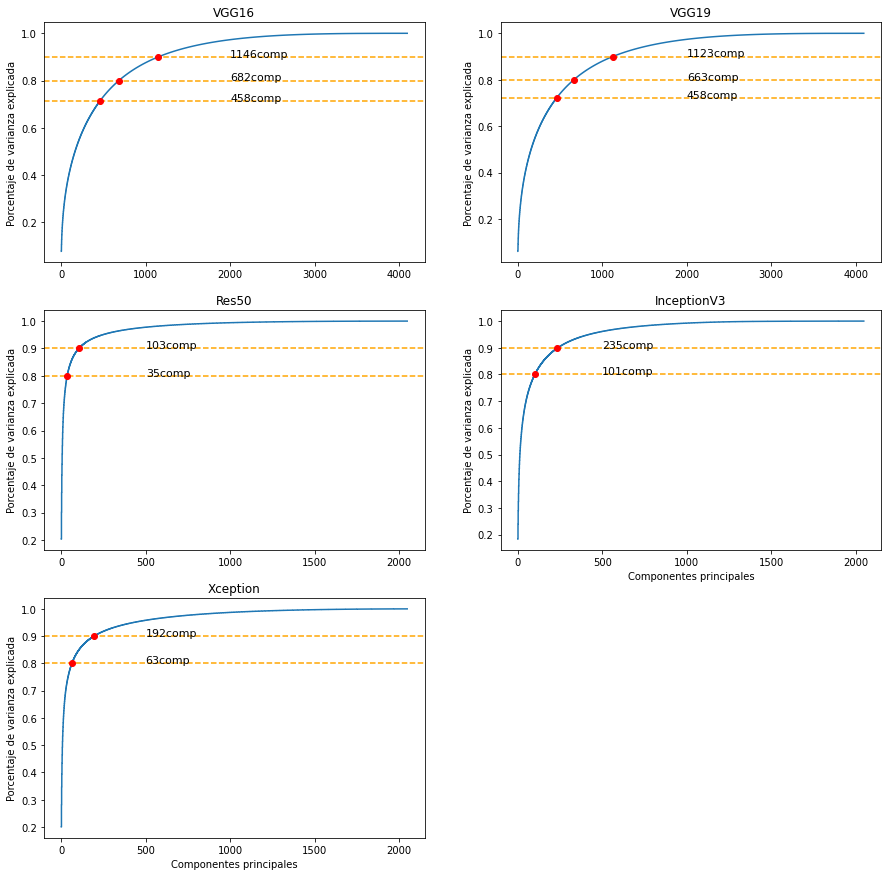

In [ ]:
cum_var_exp=[cum_var_exp16,cum_var_exp19,cum_var_expres50,cum_var_expv3,cum_var_expx]
cnn=['VGG16','VGG19','Res50','InceptionV3','Xception']
ochenta=[]
noventa=[]

import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i in range(5):
    ax = axs[i//2, i%2]
    ax.step(range(1, len(cum_var_exp[i])+1), cum_var_exp[i], where='mid',
          label='Varianza explicada acumulada')
    ax.set_ylabel('Porcentaje de varianza explicada')

    ax.set_title(cnn[i])
    ax.axhline(y = 0.8, color = 'orange', linestyle = '--', label = "80%")
    ax.axhline(y = 0.9, color = 'orange', linestyle = '--', label = "90%")

    a=np.where((cum_var_exp[i]>=0.8)&(cum_var_exp[i]<=0.9))
    ochs=str(a[0][0])+'comp'
    novs=str(a[0][-1])+'comp'
    och=int(a[0][0])
    nov=int(a[0][-1])

    ochenta.append(och)
    noventa.append(nov)

    if i==0:
      ax.text(2000, 0.8, ochs, fontsize = 11, color = 'black')
      ax.text(2000, 0.9, novs, fontsize = 11, color = 'black')
      ax.text(2000, cum_var_exp16[458], "458comp", fontsize = 11, color = 'black')
      ax.scatter([och],[0.8], color='red', zorder=5)
      ax.scatter([nov],[0.9], color='red', zorder=5)
      ax.scatter([458],[cum_var_exp16[458]], color='red', zorder=5)
      ax.axhline(y = cum_var_exp16[458], color = 'orange', linestyle = '--')


    elif i==1:
      ax.text(2000, 0.8, ochs, fontsize = 11, color = 'black')
      ax.text(2000, 0.9, novs, fontsize = 11, color = 'black')
      ax.text(2000, cum_var_exp19[458], "458comp", fontsize = 11, color = 'black')
      ax.scatter([och],[0.8], color='red', zorder=5)
      ax.scatter([nov],[0.9], color='red', zorder=5)
      ax.scatter([458],[cum_var_exp19[458]], color='red', zorder=5)
      ax.axhline(y = cum_var_exp19[458], color = 'orange', linestyle = '--')

    else:
      ax.text(500, 0.8, ochs, fontsize = 11, color = 'black')
      ax.text(500, 0.9, novs, fontsize = 11, color = 'black')
      ax.scatter([och],[0.8], color='red', zorder=5)
      ax.scatter([nov],[0.9], color='red', zorder=5)

    if i==4:
      ax.set_xlabel('Componentes principales')
    elif i==3:
      ax.set_xlabel('Componentes principales')

axs[2,1].axis('off')
plt.show()



En el grafico podemos ver que cada extractor tiene diferentes cantidad de componentes que explican la varianza. Por ello lo que vamos a hacer es tomar todos los componentes que explican el 90% de la varianza, con esto reducimos el tamaño de los vectores de caracteristicas perdiendo la menor cantidad de información posible.

Entonces la cosa quedó asi:

| Extractor CNN | Componentes 70% var | Componentes 80% var | Componentes 90% var |
|-------|------|-------|--|
| VGG16 |<center>**458**</center>| <center>682</center> | <center>1146</center> |
| VGG19 | <center>**458**</center>|<center>663</center> | <center>1123</center> |
| Res50 | <center>x</center>|<center>35</center> | <center>**103**</center> |
| InceptionV3| <center>x</center>| <center>101</center> | <center>**235**</center> |
| Xception |<center>x</center>| <center>63</center> | <center>**192**</center> |


Sin embargo, dado que el número de componentes en un Análisis de Componentes Principales (PCA) no puede ser mayor que el número de muestras (filas) porque la cantidad de componentes es una medida de la dimensionalidad reducida del conjunto de datos. Si el número de componentes es mayor que el número de muestras, no hay suficientes datos para describir los componentes y el PCA no puede realizarse. Esto produce un error ya que se requiere una matriz cuadrada para realizar las operaciones matriciales necesarias para calcular los componentes principales, entonces debemos utilizar el mismo numero de muestras como maxima cantidad de componentes principales, es decir, trabajaremos con 458 componentes principales para VGG16 y VGG19, esto nos proporciona una varianza acumulada explicada de 71% en VGG16 y de 72% en VGG19, en los demas extractores si se seguirá con el plan de reducir hasta el 90%

In [ ]:
noventa[0]=458
noventa[1]=458

In [ ]:
noventa #esta es una lista que contiene el numero de componentes principales que voy a utilizar para cara extractor

[458, 458, 103, 235, 192]

comienzo instanciando todos los grupos. 5 extractores * 10 grupos cda uno = 50 grupos

In [ ]:
#grupos de VGG16
VGG16_G = [features_1R_full_VGG16_Groups[i] for i in range(1, 11)]

#grupos de VGG19
VGG19_G = [features_1R_full_VGG19_Groups[i] for i in range(1, 11)]

#grupos de Resnet50
Res_G = [features_1R_full_res50_Groups[i] for i in range(1, 11)]

#grupos de InceptionV3
v3_G = [features_1R_full_v3_Groups[i] for i in range(1, 11)]

#grupos de Xception
x_G = [features_1R_full_x_Groups[i] for i in range(1, 11)]

ahora uso la reducción dimensional

In [ ]:
#reduccion dimensional de los grupos vgg16
for i in range(10):
    nombre_variable = "VGG16_G" + str(i) + "_PCA"
    globals()[nombre_variable] = dim_reduction_PCA(VGG16_G[i],noventa[0])[1]

#reduccion dimensional de los grupos vgg19
for i in range(10):
    nombre_variable = "VGG19_G" + str(i) + "_PCA"
    globals()[nombre_variable] = dim_reduction_PCA(VGG19_G[i],noventa[1])[1]

#reduccion dimensional de los grupos Res50
for i in range(10):
    nombre_variable = "Res_G" + str(i) + "_PCA"
    globals()[nombre_variable] = dim_reduction_PCA(Res_G[i],noventa[2])[1]

#reduccion dimensional de los grupos Inceptionv3
for i in range(10):
    nombre_variable = "v3_G" + str(i) + "_PCA"
    globals()[nombre_variable] = dim_reduction_PCA(v3_G[i],noventa[3])[1]

#reduccion dimensional de los grupos Xception
for i in range(10):
    nombre_variable = "x_G" + str(i) + "_PCA"
    globals()[nombre_variable] = dim_reduction_PCA(x_G[i],noventa[4])[1]

listo!...pilas que para evitar escribir tanto codigo instancie las variables desde el for-loop y para que las variables se pudieran llamar desde fuera del loop (variables globales) y no solo desde dentro del loop (variables locales) utilicé la funcion globals().

Asi pues, el programa siempre marcará en amarillo estas vaariables (grupos), ej: v3_G9_PCA, VGG16_G1_PCA y dirá que no estan definidas pero si lo estan

#Utilizando Agglomerative clustering

comenzamos creando una lista que cotiene el nombre de las variables a las que se les hizo la reducción dimensional (i.e. VGG16_G0_PCA). esto para facilitar mas adelante trabajar iterativamente en bucle

In [ ]:
contador=0
grupos=[]

while contador<5:
  if contador==0:
    for i in range(10):
      x='VGG16_G'+str(i)+'_PCA'
      grupos.append(x)
  elif contador==1:
    for i in range(10):
      x='VGG19_G'+str(i)+'_PCA'
      grupos.append(x)
  elif contador==2:
    for i in range(10):
      x="Res_G" + str(i) + "_PCA"
      grupos.append(x)
  elif contador==3:
    for i in range(10):
      x="v3_G" + str(i) + "_PCA"
      grupos.append(x)
  elif contador==4:
    for i in range(10):
      x="x_G" + str(i) + "_PCA"
      grupos.append(x)
  contador+=1

In [ ]:
sil_AC={}
cop_AC={}
dabo_AC={}
cali_AC={}

for i in tqdm(grupos, desc="progreso"):
    points_array = eval(i) #de la lista obtengo el nombre de las variables pero estan como str y utilizo eval para quitar las '' y que se obtenga el valor de la variable
    nombre_variable = str(i) #esto podria omitirlo pero igual lo dejo para no confundirme. esto es el nombre que le voy a dar a cada instancia dentro del diccionario

    sil, cop, dabo, cali = metodos_agglomerative(points_array)#aqui hago el kmean y extraigo las metricas

    sil_AC[nombre_variable]=sil# creo diccionario para silueta
    cop_AC[nombre_variable]=cop# creo diccionario para cophenetica
    dabo_AC[nombre_variable]=dabo# creo diccionario para Davies-Bouldin
    cali_AC[nombre_variable]=cali# creo diccionario para silueta


progreso: 100%|██████████| 50/50 [06:45<00:00,  8.11s/it]


In [ ]:
save_model(sil_AC,'/content/drive/MyDrive/Modelos_TesisMaster/PKL/sil_AC.pkl')
save_model(cop_AC,'/content/drive/MyDrive/Modelos_TesisMaster/PKL/cop_AC.pkl')
save_model(dabo_AC,'/content/drive/MyDrive/Modelos_TesisMaster/PKL/dabo_AC.pkl')
save_model(cali_AC,'/content/drive/MyDrive/Modelos_TesisMaster/PKL/cali_AC.pkl')

## Método Silhouette Score

In [ ]:
clusters=list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))


df_sil = pd.DataFrame(sil_AC)

fig = px.line(df_sil, x=clusters, y=df_sil.columns.values.tolist(), color='variable', labels={'x':"Number of clusters", 'y': 'Silhouette Score'},
              title="Silhouette Score")

fig.update_yaxes(title_text='Silhouette Score')
#fig.update_layout(yaxis_range=[-1,1])
fig.show()

## Método del índice de Calinski-Harabasz

In [ ]:
clusters=list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))


df_cali = pd.DataFrame(cali_AC)

fig = px.line(df_cali, x=clusters, y=df_cali.columns.values.tolist(), color='variable', labels={'x':"Number of clusters", 'y': 'Silhouette Score'},
              title="Calinski-Harabasz method")

fig.update_yaxes(title_text='Calinski-Harabasz Score')
fig.show()


NameError: ignored

## Método del índice de cophenética

In [ ]:
clusters=list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))


df_sil = pd.DataFrame(cop_AC)

fig = px.line(df_sil, x=clusters, y=df_sil.columns.values.tolist(), color='variable', labels={'x':"Number of clusters", 'y': 'Silhouette Score'},
              title="Silhouette Score")

fig.update_yaxes(title_text='Silhouette Score')
#fig.update_layout(yaxis_range=[-1,1])
fig.show()

In [ ]:
#el número óptimo de clústeres
for i in grupos:
  optimal_k = np.argmax(cop_AC[i])
  optimal_k_2=clusters[optimal_k]
  print(f"Optimal number of clusters to {i}: {optimal_k_2}")

Optimal number of clusters to VGG16_G0_PCA: 2
Optimal number of clusters to VGG16_G1_PCA: 2
Optimal number of clusters to VGG16_G2_PCA: 2
Optimal number of clusters to VGG16_G3_PCA: 2
Optimal number of clusters to VGG16_G4_PCA: 2
Optimal number of clusters to VGG16_G5_PCA: 2
Optimal number of clusters to VGG16_G6_PCA: 2
Optimal number of clusters to VGG16_G7_PCA: 2
Optimal number of clusters to VGG16_G8_PCA: 2
Optimal number of clusters to VGG16_G9_PCA: 2
Optimal number of clusters to VGG19_G0_PCA: 2
Optimal number of clusters to VGG19_G1_PCA: 2
Optimal number of clusters to VGG19_G2_PCA: 2
Optimal number of clusters to VGG19_G3_PCA: 2
Optimal number of clusters to VGG19_G4_PCA: 2
Optimal number of clusters to VGG19_G5_PCA: 2
Optimal number of clusters to VGG19_G6_PCA: 2
Optimal number of clusters to VGG19_G7_PCA: 2
Optimal number of clusters to VGG19_G8_PCA: 2
Optimal number of clusters to VGG19_G9_PCA: 2
Optimal number of clusters to Res_G0_PCA: 2
Optimal number of clusters to Res_G1

## Método del índice de Davies-Bouldin

In [ ]:
clusters=list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))


df_sil = pd.DataFrame(dabo_AC)

fig = px.line(df_sil, x=clusters, y=df_sil.columns.values.tolist(), color='variable', labels={'x':"Number of clusters", 'y': 'Silhouette Score'},
              title="Silhouette Score")

fig.update_yaxes(title_text='Silhouette Score')
#fig.update_layout(yaxis_range=[-1,1])
fig.show()

In [ ]:
#el número óptimo de clústeres
for i in grupos:
  optimal_k = np.argmax(dabo_AC[i])
  optimal_k_2=clusters[optimal_k]
  print(f"Optimal number of clusters to {i}: {optimal_k_2}")

Optimal number of clusters to VGG16_G0_PCA: 5
Optimal number of clusters to VGG16_G1_PCA: 6
Optimal number of clusters to VGG16_G2_PCA: 5
Optimal number of clusters to VGG16_G3_PCA: 5
Optimal number of clusters to VGG16_G4_PCA: 4
Optimal number of clusters to VGG16_G5_PCA: 3
Optimal number of clusters to VGG16_G6_PCA: 5
Optimal number of clusters to VGG16_G7_PCA: 4
Optimal number of clusters to VGG16_G8_PCA: 5
Optimal number of clusters to VGG16_G9_PCA: 4
Optimal number of clusters to VGG19_G0_PCA: 4
Optimal number of clusters to VGG19_G1_PCA: 4
Optimal number of clusters to VGG19_G2_PCA: 3
Optimal number of clusters to VGG19_G3_PCA: 4
Optimal number of clusters to VGG19_G4_PCA: 4
Optimal number of clusters to VGG19_G5_PCA: 4
Optimal number of clusters to VGG19_G6_PCA: 6
Optimal number of clusters to VGG19_G7_PCA: 6
Optimal number of clusters to VGG19_G8_PCA: 4
Optimal number of clusters to VGG19_G9_PCA: 3
Optimal number of clusters to Res_G0_PCA: 3
Optimal number of clusters to Res_G1

Segun esta prueba el numero maximo de cllusters qu se encontraron fue 8, sin embargo, dada la manipulacion de los datos que se hizo en las primeras etapas, se sabe que hay mas de 8 vocalizaciones diferentes. Vamos a hacer la prueba ploteando los clusters

### pruebas de visualizacion de los clusters

In [ ]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model.fit(VGG16_G0_PCA)
labels_vgg16_0_AC = model.labels_

etiquetas_vgg16_0=list(features_1R_full_VGG16_Groups[1].keys())
df=pd.DataFrame({'individuo':etiquetas_vgg16_0, 'labels':list(labels_vgg16_0_AC)})

duplicados = df['labels'].duplicated()

In [ ]:
df.individuo[df.labels==2]

1       XC728445_1
2       XC728444_3
6       XC723373_5
7       XC711290_1
8      XC705153_11
          ...     
448       XC7276_1
450       XC5917_5
452       XC2458_3
454       XC1641_7
456       XC1443_2
Name: individuo, Length: 149, dtype: object

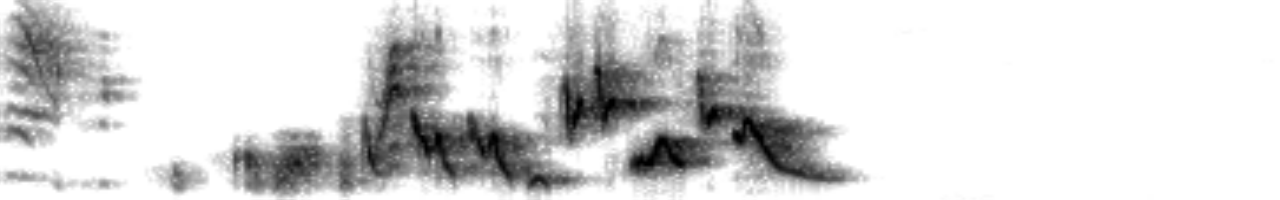

In [ ]:
spectrogramas44k['XC728445_1']

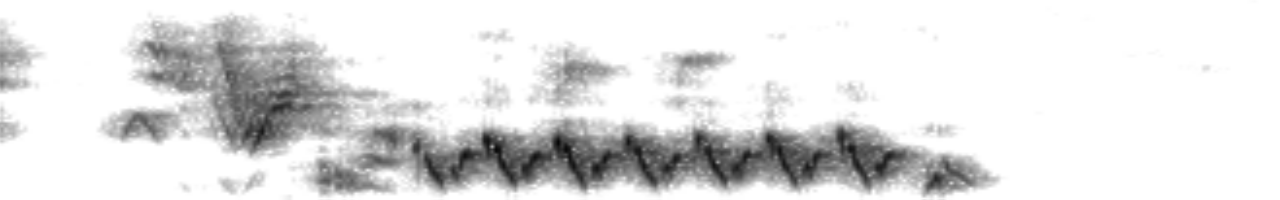

In [ ]:
spectrogramas44k['XC728444_3']

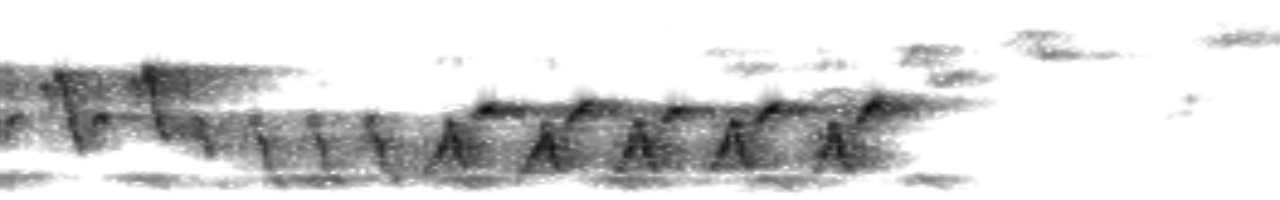

In [ ]:
spectrogramas44k['XC723373_5']

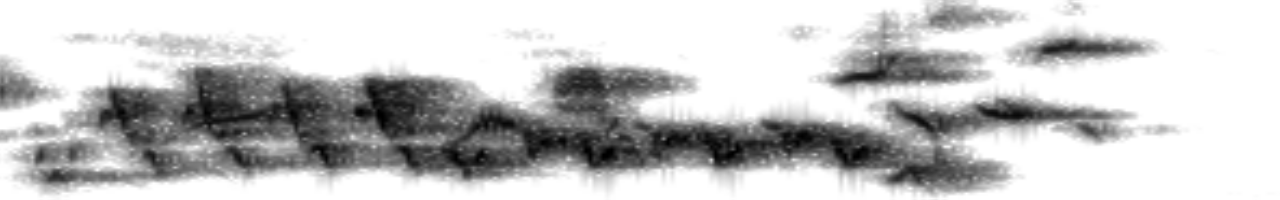

In [ ]:
spectrogramas44k['XC711290_1']

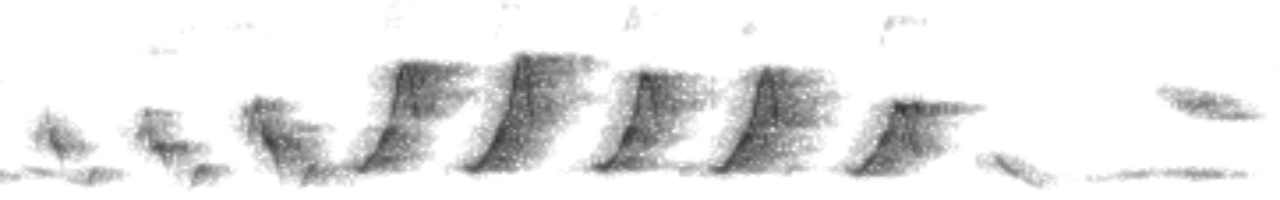

In [ ]:
spectrogramas44k['XC705153_11']

aqui nos damos cuenta que en un solo cluster hay 5 individuos con vocalizaciones totalmente diferentes, por lo que es erroneo pensar que hay solo 5 cllusters, vamos a intentar con otro grupo, esta vez extraido con xception

In [ ]:
model = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
model.fit(x_G2_PCA)
labels_x_2_AC = model.labels_

etiquetas_x_2=list(features_1R_full_x_Groups[3].keys())
df=pd.DataFrame({'individuo':etiquetas_x_2, 'labels':list(labels_x_2_AC)})

duplicados = df['labels'].duplicated()

In [ ]:
df.individuo[df.labels==2]

30     XC662626_26
39      XC645572_4
43      XC627063_4
49     XC618314_16
55      XC603268_5
85     XC558722_15
97      XC540301_7
98      XC539933_5
101     XC538222_2
104     XC537625_2
111    XC502046_70
120     XC491641_1
125     XC485234_4
138     XC460967_8
153    XC451419_14
159     XC442581_2
160     XC440010_2
178     XC411352_2
208    XC361403_10
210     XC357866_4
214     XC351592_5
219     XC351129_8
225     XC346342_5
252     XC320265_1
265     XC312410_3
272     XC304858_4
276     XC296757_2
289     XC276593_6
294     XC272885_6
298     XC269519_4
301     XC262414_2
304     XC259366_3
305     XC259364_4
308     XC259361_4
310     XC254212_1
322     XC233124_3
360    XC190041_18
401      XC80357_2
450       XC5917_1
Name: individuo, dtype: object

In [ ]:
for i in df.individuo[df.labels==2].tolist()[:10] :
  print(f"spectrogramas44k['{i}']")

spectrogramas44k['XC662626_26']
spectrogramas44k['XC645572_4']
spectrogramas44k['XC627063_4']
spectrogramas44k['XC618314_16']
spectrogramas44k['XC603268_5']
spectrogramas44k['XC558722_15']
spectrogramas44k['XC540301_7']
spectrogramas44k['XC539933_5']
spectrogramas44k['XC538222_2']
spectrogramas44k['XC537625_2']


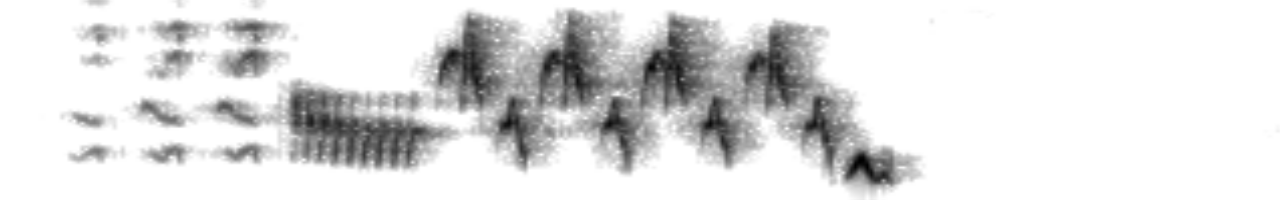

In [ ]:
spectrogramas44k['XC662626_26']

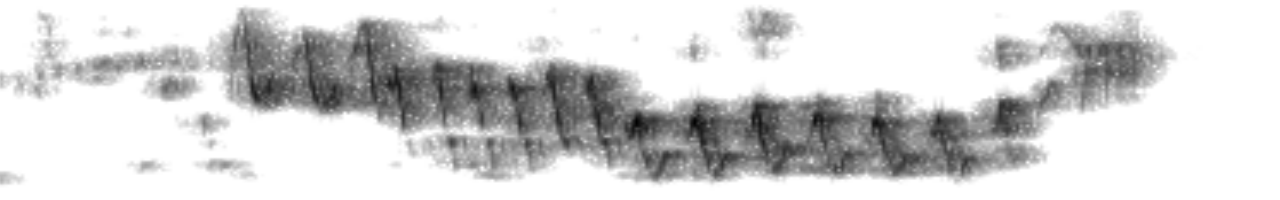

In [ ]:
spectrogramas44k['XC645572_4']

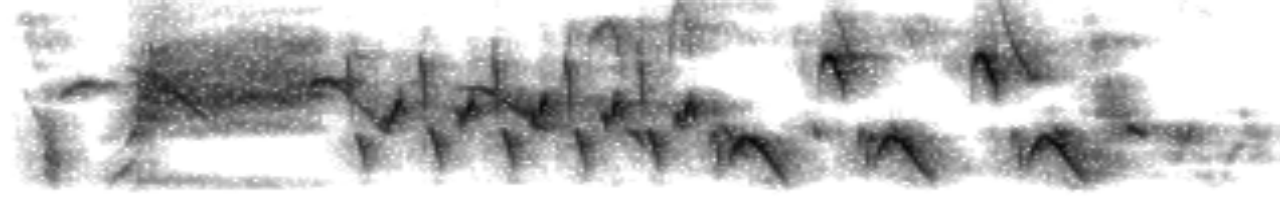

In [ ]:
spectrogramas44k['XC627063_4']

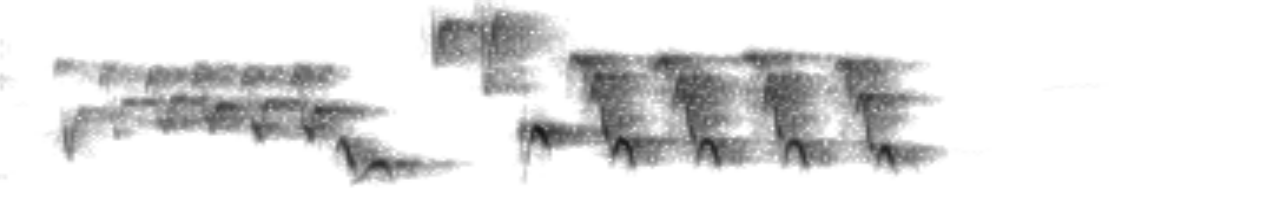

In [ ]:
spectrogramas44k['XC618314_16']

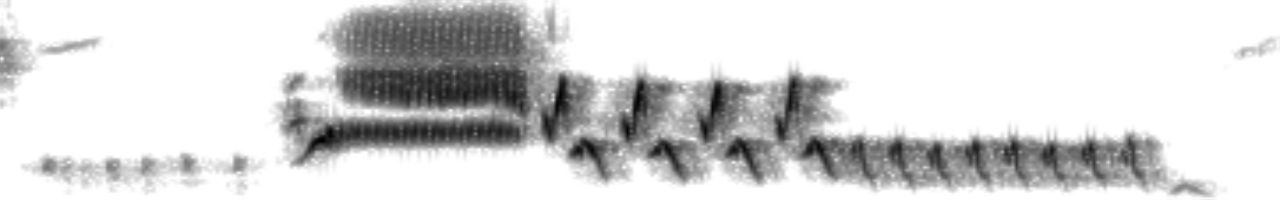

In [ ]:
spectrogramas44k['XC603268_5']

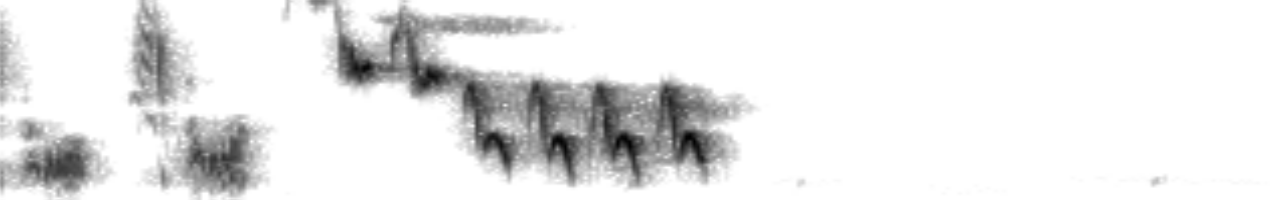

In [ ]:
spectrogramas44k['XC558722_15']

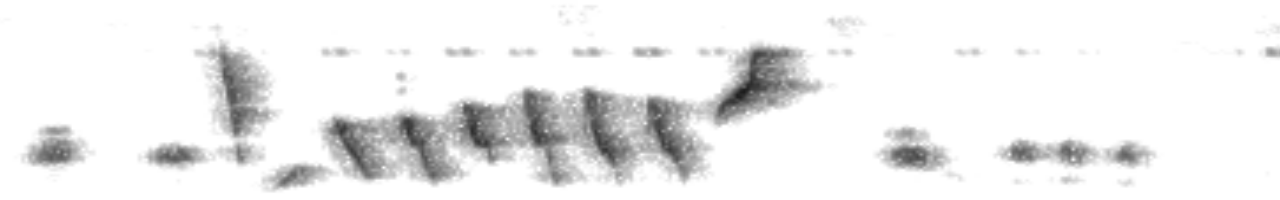

In [ ]:
spectrogramas44k['XC540301_7']

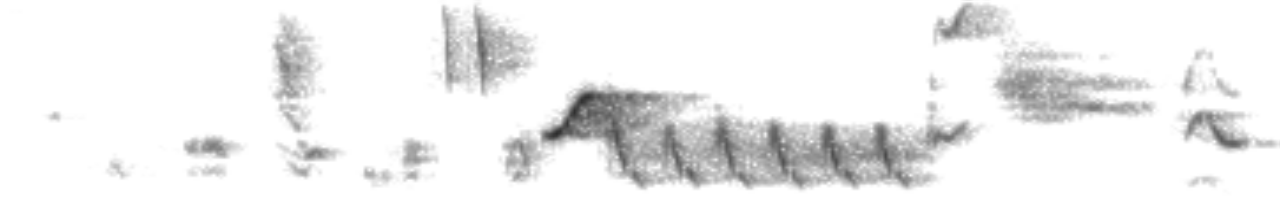

In [ ]:
spectrogramas44k['XC539933_5']

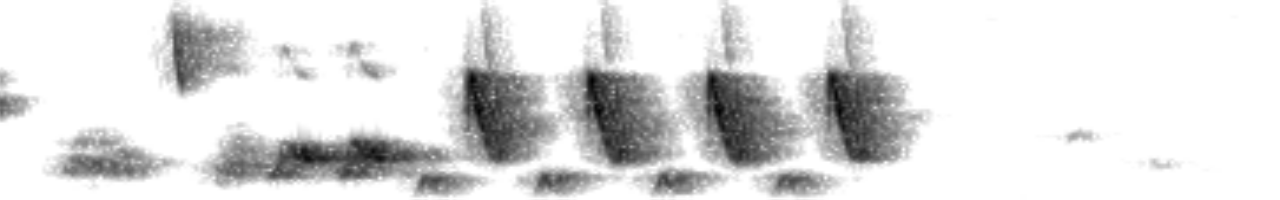

In [ ]:
spectrogramas44k['XC538222_2']

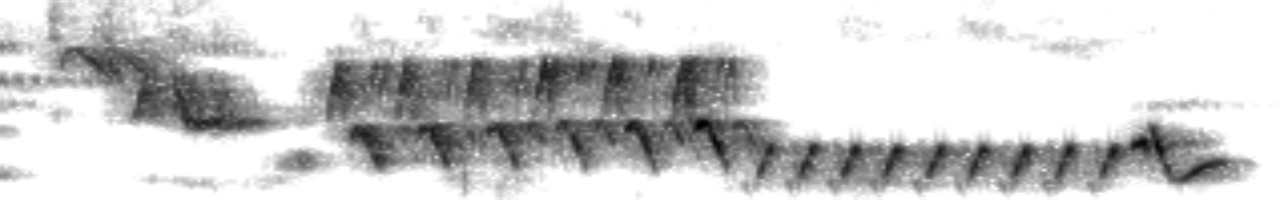

In [ ]:
spectrogramas44k['XC537625_2']

como vemos de nuevo, en el mismo cluster encontramos 10 individuos con vocalizaciones totalmente diferentes, esto lo que me quire dar a entender es que los resultados obtenidos con el metodo Davies-Bouldin no son correctos. Todos los demas metodos arrojan que no hay ni un solo cluster y este fue el unico metodo que arrojó estos resultados tan raros. por ello no se va a tomar en cuenta y seguiremos con la premisa de que todos los cantos son diferentes

#Utilizando K-means

comenzamos aplicando el K-means a cada uno de los grupos, sin embargo, cual es el numero de clusters optimo para darle como parametro al algoritmo?.

Como no lo sabemos entonces vamos a utilizar 3 metodos que nos pueden indicar cual es ese k optimo: el metodo del codo, el metodo de silueta u el metodo de calinski. Para ello debo hacer un loop que a cada grupo le aplique el kmean con x numero de clusters, luego x+1 numero de clusters y asi sucesivamente hasta 458 que seria el maximo que se puede tener. Este loop ademas se encarga aplicar los metodos antes nombrados y proporcionarnos un diccionario para cada metodo, en este diccinario estan los valores del analisis y solo es plotearlos para ver cual es el k optimo.

In [ ]:
sse_elb={}
scores_sil={}
scores_cali={}

for i in tqdm(grupos, desc="progreso"):
    points_array = eval(i) #de la lista obtengo el nombre de las variables pero estan como str y utilizo eval para quitar las '' y que se obtenga el valor de la variable
    nombre_variable = str(i) #esto podria omitirlo pero igual lo dejo para no confundirme. esto es el nombre que le voy a dar a cada instancia dentro del diccionario

    elb, sil, cali = metodos_kmeans(points_array)#aqui hago el kmean y extraigo las metricas

    sse_elb[nombre_variable]=elb# creo el diccionario para codo
    scores_sil[nombre_variable]=sil# creo diccionario para silueta
    scores_cali[nombre_variable]=cali# creo diccionario para calinski



progreso: 100%|██████████| 50/50 [11:06<00:00, 13.32s/it]


pilas que este codigo demos 1h 16 minutos en ejecutarse

In [ ]:
save_model(sse_elb,'/content/drive/MyDrive/Modelos_TesisMaster/PKL/sse_elb.pkl')
save_model(scores_sil,'/content/drive/MyDrive/Modelos_TesisMaster/PKL/scores_sil.pkl')
save_model(scores_cali,'/content/drive/MyDrive/Modelos_TesisMaster/PKL/scores_cali.pkl')

In [ ]:
sse_elb=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/sse_elb.pkl')
scores_sil=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/scores_sil.pkl')
scores_cali=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/scores_cali.pkl')

La funcion metodos_kmeans se creó para evaluar desde clusters= 2 hasta 458 con saltos de 20 (e.g. 2-22-42...402-422-442). Se diseñó asi porque no es posible inicializarla desde 0 (no pueden haber 0 clusters) y tampoco desde 1 (dado que durante la primera iteracion n_clusters=1, por lo que kmeans.labels_==0, es decir, tendriamos un cluster con label 0, algo que no es posible), solo se puede iniciar desde 2. los 458 son referente a la cantidad de individuos y los 20 saltos es porque al evaluar independientemente una cantidad x de clusters en cada paso, cuando la cantidad de clusters aumenta, el calculo se vuelve muy pesado y el tiempo que le toma a la maquina es demasiado. Por dar un ejemplo, para que se termine de calcular el scores_silhouettes de 1 solo grupo (son 50) cuando el salto es de 1 es de aprox 50min.  
Esto son aprox 42horas de procesamiento para los 50 grupos. Algo que no es posible hacerse dado que colab se cerraria y se perderia toda la información.

## Método del codo (Elbow Method)

In [ ]:
# Loop over different values of k (number of clusters)
for i in grupos:
    x=eval(i)
    # Create kmeans model
    kmeans = KMeans(n_clusters=1, random_state=42)
    # Fit the model to the data
    kmeans.fit(x)
    # Append SSE value for k clusters to the list
    sse_elb[i].insert(0,kmeans.inertia_)

In [ ]:
clusters_m=[1]+list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))


df_sse = pd.DataFrame(sse_elb)

fig = px.line(df_sse, x=clusters_m, y=df_sse.columns.values.tolist(), color='variable', labels={'x':"Number of clusters", 'y': 'SSE'},
              title="Elbow method")

fig.update_yaxes(title_text='SSE')
fig.show()


## Método Silhouette Score

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

$$ s = \frac{b - a}{max(a, b)} $$

**References**

Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis” . Computational and Applied Mathematics 20: 53–65.

In [ ]:
clusters=list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))


df_sil = pd.DataFrame(scores_sil)

fig = px.line(df_sil, x=clusters, y=df_sil.columns.values.tolist(), color='variable', labels={'x':"Number of clusters", 'y': 'Silhouette Score'},
              title="Silhouette Score")

fig.update_yaxes(title_text='Silhouette Score')
#fig.update_layout(yaxis_range=[-1,1])
fig.show()

In [ ]:
# El número de clústeres en el punto de codo se considera el número óptimo
for i in grupos:
  optimal_k = np.argmax(scores_sil[i])
  optimal_k_2=clusters[optimal_k]
  print(f"Optimal number of clusters to {i}: {optimal_k_2}")

Optimal number of clusters to VGG16_G0_PCA: 2
Optimal number of clusters to VGG16_G1_PCA: 2
Optimal number of clusters to VGG16_G2_PCA: 2
Optimal number of clusters to VGG16_G3_PCA: 2
Optimal number of clusters to VGG16_G4_PCA: 2
Optimal number of clusters to VGG16_G5_PCA: 2
Optimal number of clusters to VGG16_G6_PCA: 2
Optimal number of clusters to VGG16_G7_PCA: 2
Optimal number of clusters to VGG16_G8_PCA: 2
Optimal number of clusters to VGG16_G9_PCA: 2
Optimal number of clusters to VGG19_G0_PCA: 2
Optimal number of clusters to VGG19_G1_PCA: 2
Optimal number of clusters to VGG19_G2_PCA: 2
Optimal number of clusters to VGG19_G3_PCA: 2
Optimal number of clusters to VGG19_G4_PCA: 2
Optimal number of clusters to VGG19_G5_PCA: 2
Optimal number of clusters to VGG19_G6_PCA: 2
Optimal number of clusters to VGG19_G7_PCA: 2
Optimal number of clusters to VGG19_G8_PCA: 2
Optimal number of clusters to VGG19_G9_PCA: 2
Optimal number of clusters to Res_G0_PCA: 2
Optimal number of clusters to Res_G1

En este caso el metodo de silueta nos arroja que el numero optimo de clusters tiende a 0, sin embargo, esto hay que cogerlo con pinzas dado que si observamos en el código, por convencion yo estoy empezando desde 2 (desde 1 o 0 genera error) y por ende la cantidad minima de clusters será 2. No obstante la grafica parece mostrar que entre menos clusters se formen, mayor será el score. Ademas, en la practica, si se toman 3 espectrogrmas de individuos diferentes (del norte, centro y sur-america) lo mas probables es que sean diferentes y por tanto no es logico que solo hayan 2 clusters.
Tambien cabe notar que el score de silueta varia entre -1 y 1, y estamos obteniendo scores muy bajos, tan solo el mas alto es de 0.149.
Finalmente, esta prueba nos muestra que no se pueden encontrar clusters. No se pueden agrupar de alguna manera los espectrogramas

The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

## Método del índice de Calinski-Harabasz

If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)

The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

The score is fast to compute.

The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

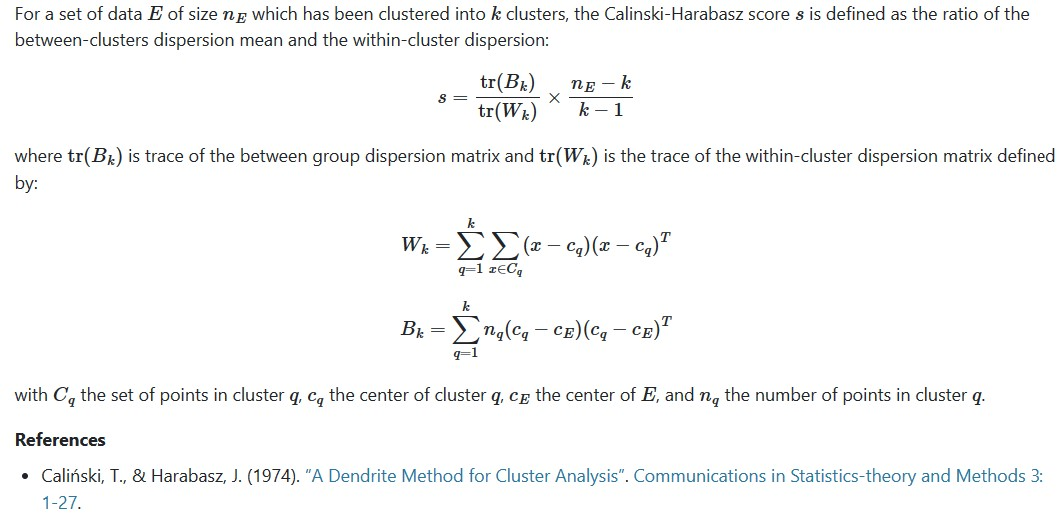

In [ ]:
clusters=list(range(2, 22))+list(range(22, 458,20))+list((range(450, 458)))


df_cali = pd.DataFrame(scores_cali)

fig = px.line(df_cali, x=clusters, y=df_cali.columns.values.tolist(), color='variable', labels={'x':"Number of clusters", 'y': 'Silhouette Score'},
              title="Calinski-Harabasz method")

fig.update_yaxes(title_text='Calinski-Harabasz Score')
fig.show()


In [ ]:
# El número de clústeres en el punto de codo se considera el número óptimo
for i in grupos:
  optimal_k = np.argmax(scores_cali[i])
  optimal_k_2=clusters[optimal_k]
  print(f"Optimal number of clusters to {i}: {optimal_k_2}")

Optimal number of clusters to VGG16_G0_PCA: 2
Optimal number of clusters to VGG16_G1_PCA: 2
Optimal number of clusters to VGG16_G2_PCA: 2
Optimal number of clusters to VGG16_G3_PCA: 2
Optimal number of clusters to VGG16_G4_PCA: 2
Optimal number of clusters to VGG16_G5_PCA: 2
Optimal number of clusters to VGG16_G6_PCA: 2
Optimal number of clusters to VGG16_G7_PCA: 2
Optimal number of clusters to VGG16_G8_PCA: 2
Optimal number of clusters to VGG16_G9_PCA: 2
Optimal number of clusters to VGG19_G0_PCA: 2
Optimal number of clusters to VGG19_G1_PCA: 2
Optimal number of clusters to VGG19_G2_PCA: 2
Optimal number of clusters to VGG19_G3_PCA: 2
Optimal number of clusters to VGG19_G4_PCA: 2
Optimal number of clusters to VGG19_G5_PCA: 2
Optimal number of clusters to VGG19_G6_PCA: 2
Optimal number of clusters to VGG19_G7_PCA: 2
Optimal number of clusters to VGG19_G8_PCA: 2
Optimal number of clusters to VGG19_G9_PCA: 2
Optimal number of clusters to Res_G0_PCA: 2
Optimal number of clusters to Res_G1

Se puede ver que el score mas alto en la mayoria de los casos es cuando el numero de clusters tiende a 0. Sin embargo, en el grupo 0 de Xception hay un pico cuando el numero de clusters es 456, luego cae drasticamente el score en 457 indicando que cuando se crean 456 clusters, estos son densos y aislados de los demas, , no obstante, hablar de 456 clusters es hablar de conjuntos casi unitarios, solo debe haber un o dos clusters compuestos por mas de 1 individuo...en este caso, el metodo tambien nos indica que no hay similitud entre los spectrogramas, sin embargo, no está de más investigar cuales son esos grupos que tienen mas de 1 indiviudo.

### prueba de visualizacion de clusters

In [ ]:
kmeans = KMeans(n_clusters=456, random_state=42)
kmeans.fit(x_G0_PCA)
labels = kmeans.labels_
etiquetas=list(features_1R_full_x_Groups[1].keys())

In [ ]:
df=pd.DataFrame({'individuo':etiquetas, 'labels':list(labels)})

In [ ]:
duplicados = df['labels'].duplicated()
print(df[duplicados])

      individuo  labels
23   XC690994_3      54
336  XC231541_2     319


In [ ]:
df[df.labels==54]

,individuo,labels
22,XC690997_3,54
23,XC690994_3,54


In [ ]:
df[df.labels==319]

,individuo,labels
190,XC386603_4,319
336,XC231541_2,319


In [ ]:
print(f"""
cluster 54:
{lat_labels[lat_labels['id_XC']=='XC690997']}
{lat_labels[lat_labels['id_XC']=='XC690994']}

cluster 319:
{lat_labels[lat_labels['id_XC']=='XC386603']}
{lat_labels[lat_labels['id_XC']=='XC231541']}
""")


cluster 54:
    Unnamed: 0     id_XC       cnt     lat labels
22          22  XC690997  Colombia  1.4898     5N
    Unnamed: 0     id_XC       cnt     lat labels
23          23  XC690994  Colombia  1.4898     5N

cluster 319:
     Unnamed: 0     id_XC    cnt      lat labels
190         190  XC386603  Chile -33.7836    35S
     Unnamed: 0     id_XC   cnt        lat labels
336         336  XC231541  Peru -11.333333    15S



acabamos de descubrir dos cosas interesantes; la primera es que el cluster 54 está compuesto por dos individuos de Colombia que se encuentran cerca geograficamente. Esto es bueno porque puede ser que sean dos individuos grabados en la misma localidad pero dice mucho del algoritmo, dado que fue capaz de identificar eso sin necesidad de
lo segundo es que el cluster 319 curiosamente esta compuesto por dos individuos de paises distintos, uno esta en chile y el otro en peru. Veamos que tan parecidos son los integrantes de los clusters

In [ ]:
spectrogramas44k=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/spectrogramas44k.pkl")

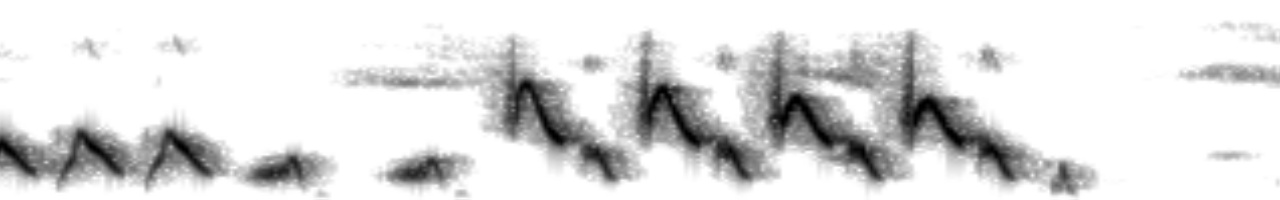

In [ ]:
spectrogramas44k['XC690997_3']

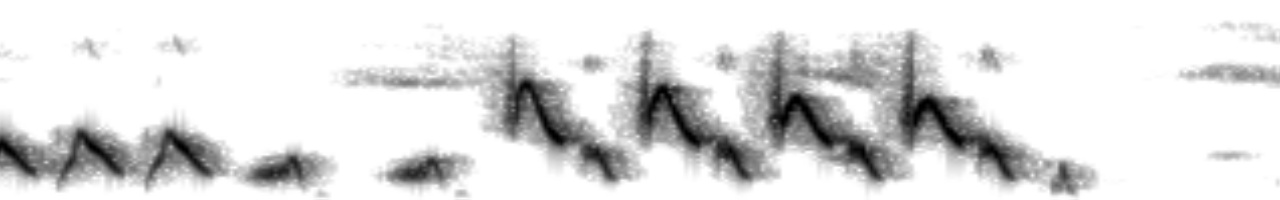

In [ ]:
spectrogramas44k['XC690994_3']

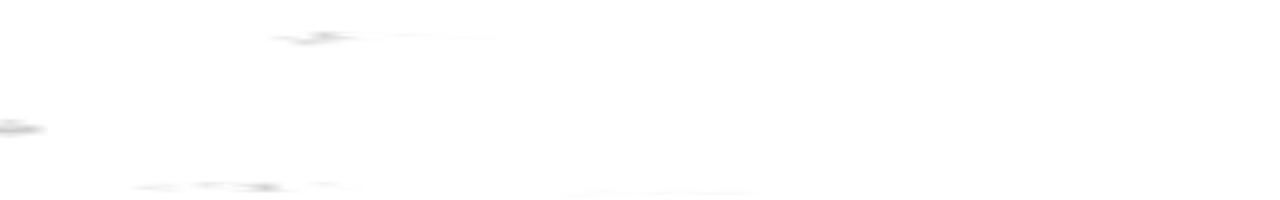

In [ ]:
spectrogramas44k['XC386603_4']

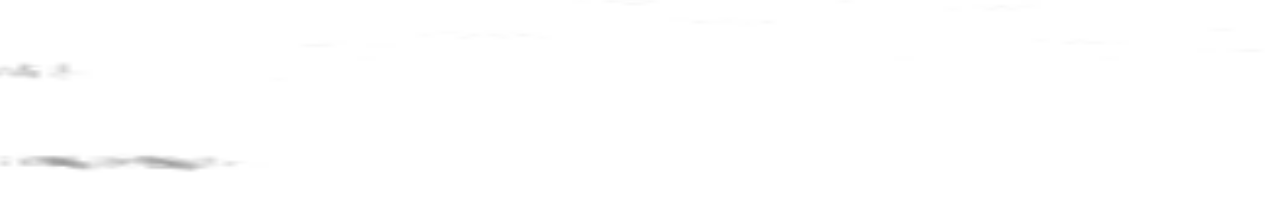

In [ ]:
spectrogramas44k['XC231541_2']

bueno, como vemos, lastimosamente no hay nada sorprendente. el cluster319 está compuesto por dos grabaciones que se segmentaron erroneamente en el proceso de segmentación, es decir, calculamos un error para el proceso, sabiamos que no era 100% certero en la segmentación y efectivamente, aqui encontramos un error. No obstante, no es un gran problema.

El cluster54 si me dejó asombrado dado que muestra que lo que está etiquetado como dos individuos distintos en xenocanto lo mas probable es que sea solo 1. me deja sorprendido porque las grabaciones de ambos individuos pasaron individualmente por todos los procesos, la extraccion de caracteristicas y la clusterización y el modelo fue capaz de identificar que son "presumiblemente" el mismo individuo y sin darle al algoritmo ninguna etiqueta de ubicacion ni nada. Es un check que me dice que el modelo funciona bien.


Pero ahora, en conclusión: No se encontraron clusters por medio de K-means, por lo que por este medio podemos asegurar que todos los individuos tienen cantos estadisticamente diferentes

# Utilizando DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en densidad que a diferrenciia de los anteriores algoritmos tiene un argumento llamado eps que hace referencia a la distancia máxima dentro de la cual se considerará que dos puntos pertenecen al mismo cluster.

ahora, debemos encontrar el valor optimo de eps. para ello utilizaremos el metodo de la rodilla (knee method) e iteraremos para ver cual eps arroja el resultado optimo

## Knee method

primero calculamos las distancias entre los vecinos

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

dist_neighbor={}

for i in grupos:
  X=eval(i)

  # Calcula la gráfica k-distancia
  nbrs = NearestNeighbors().fit(X)
  distances, indices = nbrs.kneighbors(X)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  dist_neighbor[str(i)]=distances


ahora encontramos el eps y el min_samples optimos aumentando de a poco los valores

In [ ]:
dicc_eps={}
dicc_minsamples={}

for i in grupos:
  X=eval(i)
  # Encuentra el valor óptimo de eps
  eps = 0.5  # valor inicial de eps
  min_samples = 1  # valor inicial de min_samples
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  labels = dbscan.fit_predict(X)
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  while n_clusters_ < 1:  # mientras no se encuentren al menos 2 clusters
      eps *= 1.1  # incrementar el valor de eps
      dbscan = DBSCAN(eps=eps, min_samples=min_samples)
      labels = dbscan.fit_predict(X)
      n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  dicc_eps[str(i)]=eps
  dicc_minsamples[str(i)]=min_samples

In [ ]:
import statistics as stat
moda_eps=stat.mode(list(dicc_eps.values()))
average_eps=stat.mean(list(dicc_eps.values()))
print(f"moda eps={moda_eps}, promedio eps={average_eps}")

moda eps=0.5, promedio eps=0.5


In [ ]:
save_model(dist_neighbor, "/content/drive/MyDrive/Modelos_TesisMaster/PKL/dist_neighbor.pkl" )

In [ ]:
df_dist = pd.DataFrame(dist_neighbor)

fig = px.line(df_dist, x=range(458), y=df_dist.columns.values.tolist(), color='variable',template="simple_white")



fig.update_layout(
    title="k-distancia y valor óptimo de eps",
    xaxis_title="Número de muestra",
    yaxis_title="Distancia al k-ésimo vecino más cercano",
    legend_title="Conjuntos",
    font=dict(
        family="Calibri",
        size=14),
    shapes=[
        dict(
            type="line",
            x0=0.5,
            y0=0,
            x1=0.5,
            y1=250,
            line=dict(color="red", width=3, dash='dash')
        )
    ]
    )



fig.show()

In [ ]:
moda_samples=stat.mode(list(dicc_minsamples.values()))
print(f"""
Valor óptimo de eps para todos los grupos: {moda_eps}
Valor óptimo de min_samples para todos los grupos: {moda_samples}
      """)


Valor óptimo de eps para todos los grupos: 0.5
Valor óptimo de min_samples para todos los grupos: 1 
      


nos damos cuenta que la rodilla se encuentra cuando el valor de eps es 0.5. asi que utilizamos este valor y un min_samples=1

In [ ]:
num_clus_dbscan={}

for i in grupos:
  X=eval(i)
  # Ejecuta DBSCAN en la matriz de datos con los valores óptimos encontrados
  dbscan = DBSCAN(eps=moda_eps, min_samples=moda_samples)
  dbscan.fit(X)

  # Obtiene las etiquetas de cluster asignadas a cada punto en la matriz de datos
  labels = dbscan.labels_

  # Cuenta el número de clusters encontrados
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

  num_clus_dbscan[str(i)]=n_clusters



In [ ]:
# Definir una lista con valores repetidos
val = list(num_clus_dbscan.values())

# Crear un diccionario para almacenar el recuento de valores
recuento_valores = {}

# Iterar sobre la lista
for valor in val:
    # Si el valor no está en el diccionario, inicializar su recuento a 0
    if valor not in recuento_valores:
        recuento_valores[valor] = 0
    # Incrementar el recuento del valor en el diccionario
    recuento_valores[valor] += 1

# Imprimir el recuento de valores
for valor, recuento in recuento_valores.items():
    print(f"De los 50 grupos, {recuento} tienen {valor} clusters")

De los 50 grupos, 10 tienen 457 clusters
De los 50 grupos, 40 tienen 458 clusters


encontramos que 10 grupos presentan 457 clusters, es decir, que hay 2 vocalizaciones que se parecen. miremos cuales son.

Un vistazo rapido me deja saber que los grupos en los que se presentan 457 clusters son el 0 y el 9 para todos los extractores, asi que veamos.

In [ ]:
etiquetas=list(features_1R_full_x_Groups[1].keys())

In [ ]:
df=pd.DataFrame({'individuo':etiquetas, 'labels':list(labels)})

In [ ]:
duplicados = df['labels'].duplicated()
print(df[duplicados])

     individuo  labels
23  XC690994_3      22


In [ ]:
df[df.labels==22]

,individuo,labels
22,XC690997_3,22
23,XC690994_3,22


In [ ]:
X=eval(grupos[39])
# Ejecuta DBSCAN en la matriz de datos con los valores óptimos encontrados
dbscan = DBSCAN(eps=moda_eps, min_samples=moda_samples)
dbscan.fit(X)

# Obtiene las etiquetas de cluster asignadas a cada punto en la matriz de datos
labels = dbscan.labels_

In [ ]:
etiquetas=list(features_1R_full_v3_Groups[10].keys())
df=pd.DataFrame({'individuo':etiquetas, 'labels':list(labels)})
duplicados = df['labels'].duplicated()
print(df[duplicados])

     individuo  labels
23  XC690994_2      22


In [ ]:
df[df.labels==22]

,individuo,labels
22,XC690997_2,22
23,XC690994_2,22


In [ ]:
spectrogramas44k=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/spectrogramas44k.pkl")

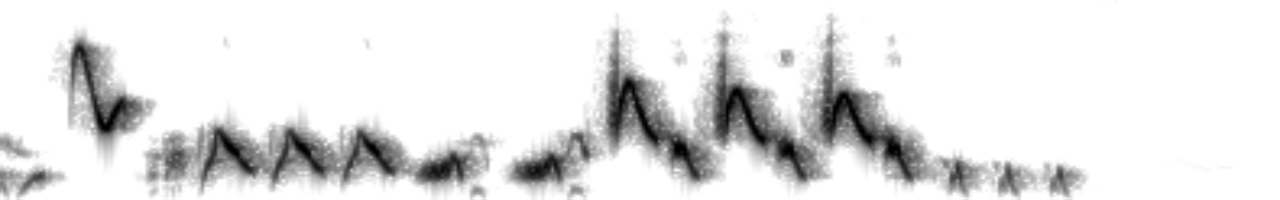

In [ ]:
spectrogramas44k['XC690997_2']

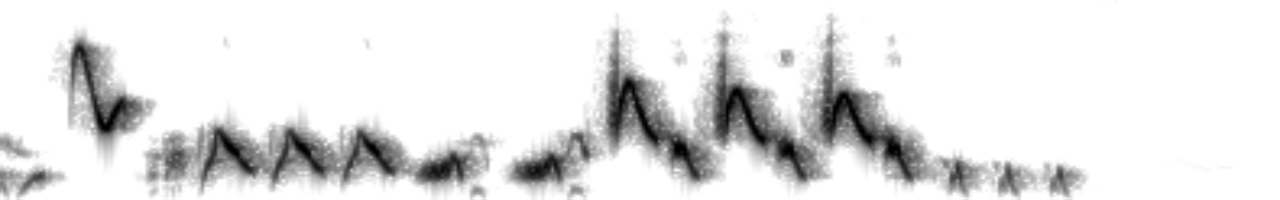

In [ ]:
spectrogramas44k['XC690994_2']

Efectivamente las vocalizaciones que encontró similares son las mismas que en los otros algortimos de clustering. La diferencia es que este algortimo encontró que en los grupos 9 tambien hay otra vocalizacion de los mismos individuos. Es decir, en el grupo 0 se encuentra la vocalizacion 3 del individuo XC690994 que es la misma del XC690997 y en el grupo 9 se encuentra la vocalizacion 2 de los mismos individuos (que es la misma). Por eso se asume que el XC690994 y el XC690997 son el mismo pajaro

# ----------------------------------

In [ ]:
VGG16_G0_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G0_PCA.pkl')
VGG16_G1_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G1_PCA.pkl')
VGG16_G2_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G2_PCA.pkl')
VGG16_G3_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G3_PCA.pkl')
VGG16_G4_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G4_PCA.pkl')
VGG16_G5_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G5_PCA.pkl')
VGG16_G6_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G6_PCA.pkl')
VGG16_G7_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G7_PCA.pkl')
VGG16_G8_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G8_PCA.pkl')
VGG16_G9_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG16_G9_PCA.pkl')
VGG19_G0_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G0_PCA.pkl')
VGG19_G1_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G1_PCA.pkl')
VGG19_G2_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G2_PCA.pkl')
VGG19_G3_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G3_PCA.pkl')
VGG19_G4_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G4_PCA.pkl')
VGG19_G5_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G5_PCA.pkl')
VGG19_G6_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G6_PCA.pkl')
VGG19_G7_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G7_PCA.pkl')
VGG19_G8_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G8_PCA.pkl')
VGG19_G9_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/VGG19_G9_PCA.pkl')
Res_G0_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G0_PCA.pkl')
Res_G1_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G1_PCA.pkl')
Res_G2_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G2_PCA.pkl')
Res_G3_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G3_PCA.pkl')
Res_G4_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G4_PCA.pkl')
Res_G5_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G5_PCA.pkl')
Res_G6_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G6_PCA.pkl')
Res_G7_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G7_PCA.pkl')
Res_G8_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G8_PCA.pkl')
Res_G9_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/Res_G9_PCA.pkl')
v3_G0_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G0_PCA.pkl')
v3_G1_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G1_PCA.pkl')
v3_G2_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G2_PCA.pkl')
v3_G3_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G3_PCA.pkl')
v3_G4_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G4_PCA.pkl')
v3_G5_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G5_PCA.pkl')
v3_G6_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G6_PCA.pkl')
v3_G7_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G7_PCA.pkl')
v3_G8_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G8_PCA.pkl')
v3_G9_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/v3_G9_PCA.pkl')
x_G0_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G0_PCA.pkl')
x_G1_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G1_PCA.pkl')
x_G2_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G2_PCA.pkl')
x_G3_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G3_PCA.pkl')
x_G4_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G4_PCA.pkl')
x_G5_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G5_PCA.pkl')
x_G6_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G6_PCA.pkl')
x_G7_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G7_PCA.pkl')
x_G8_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G8_PCA.pkl')
x_G9_PCA=load_model('/content/drive/MyDrive/Modelos_TesisMaster/PKL/x_G9_PCA.pkl')